# Predicción de Series Temporales con Redes Neuronales

### PRESENTADO POR:
  * Jorge Alberto Ruiz Leon
  * David Augusto Villabón Borja

## Usaremos Keras y Tensorflow

Importamos las Librerías que vamos a utilizar

In [123]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

In [124]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Cargamos nuestro Dataset
#### Miramos una muestra de 5 registros

In [125]:
df = pd.read_csv('/content/drive/MyDrive/Copia de time_series.csv',  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','unidades'])
df.sample(5)

fecha
2017-05-02    276
2018-08-08    317
2017-01-25    206
2017-01-12    157
2017-10-19    194
Name: unidades, dtype: int64

#### La serie tiene datos  peridos o nulos???

In [126]:
df.isna().sum()

0

#### Resumen stadistico de los datos

In [127]:
df.describe()

count    604.000000
mean     215.935430
std       75.050304
min       51.000000
25%      171.000000
50%      214.000000
75%      261.250000
max      591.000000
Name: unidades, dtype: float64

#### Chequeamos la fecha minima y maxima de la serie temporal

In [128]:
print(df.index.min())
print(df.index.max())

2017-01-02 00:00:00
2018-11-30 00:00:00


#### Contamos cantidad de registros por año

In [129]:
print(len(df['2017']))
print(len(df['2018']))

315
289


#### Media mensual de la serie

In [130]:
meses =df.resample('M').mean();meses

fecha
2017-01-31    203.923077
2017-02-28    184.666667
2017-03-31    182.964286
2017-04-30    198.960000
2017-05-31    201.185185
2017-06-30    209.518519
2017-07-31    278.923077
2017-08-31    316.000000
2017-09-30    222.925926
2017-10-31    207.851852
2017-11-30    185.925926
2017-12-31    213.200000
2018-01-31    201.384615
2018-02-28    190.625000
2018-03-31    174.846154
2018-04-30    186.000000
2018-05-31    190.666667
2018-06-30    196.037037
2018-07-31    289.500000
2018-08-31    309.038462
2018-09-30    230.518519
2018-10-31    209.444444
2018-11-30    184.481481
Freq: M, Name: unidades, dtype: float64

## Visualizaciones

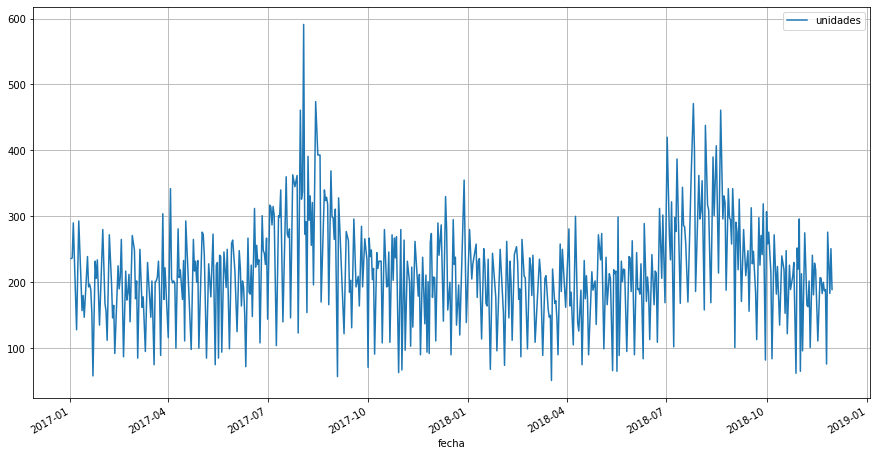

In [131]:
fig = plt.gcf()
fig.set_size_inches(15,8)
df.plot()
plt.legend()
plt.grid()
plt.show()

#### Estacionalidad

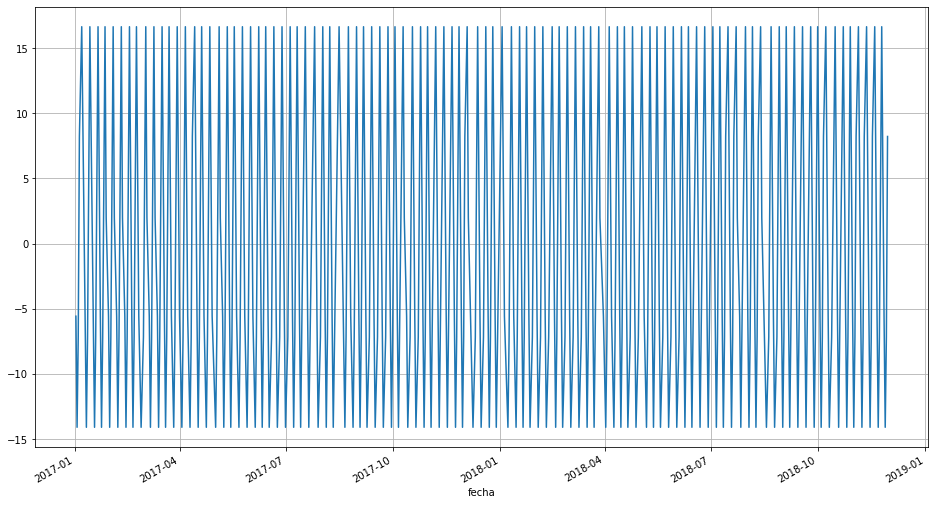

In [132]:
result=seasonal_decompose(df, model='additive',freq=6)
result.seasonal.plot()
plt.grid()
plt.show()

#### Tendencia

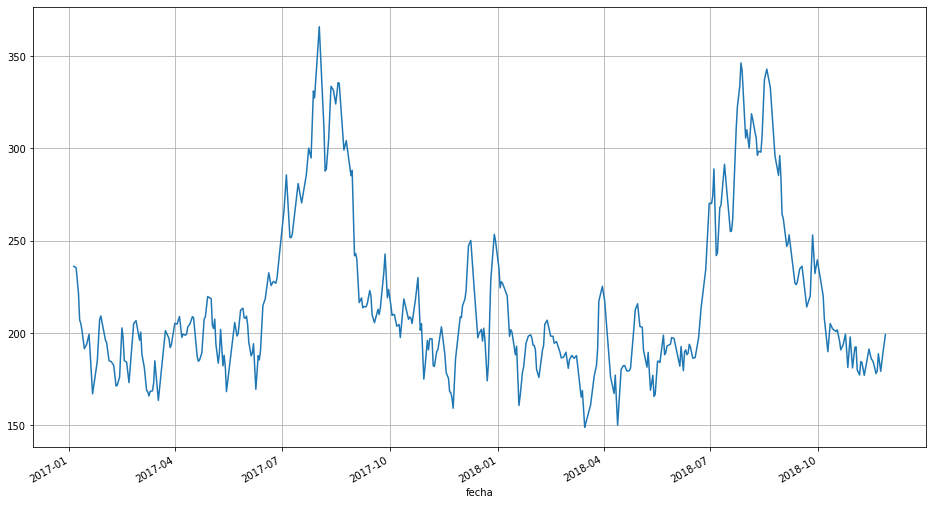

In [133]:
result.trend.plot()
plt.grid()
plt.show()

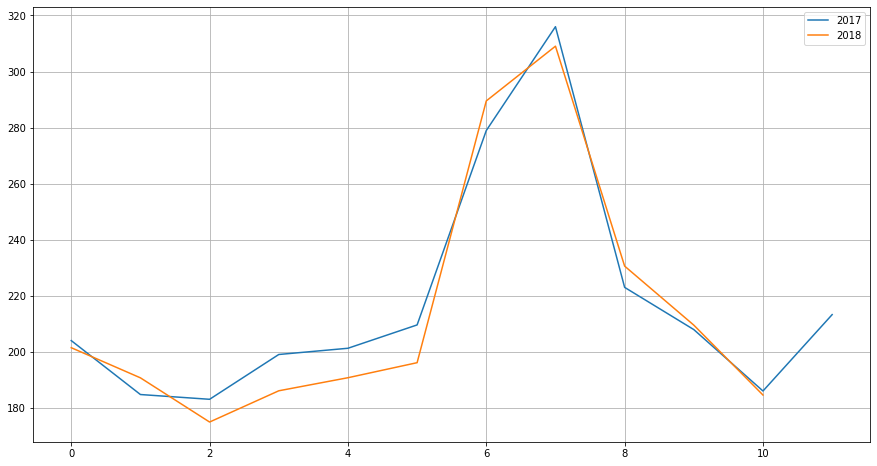

In [134]:
fig1 = plt.gcf()
fig1.set_size_inches(15,8)
plt.plot(meses['2017'].values, label="2017")
plt.plot(meses['2018'].values,label="2018")
plt.legend()
plt.grid()
plt.show()

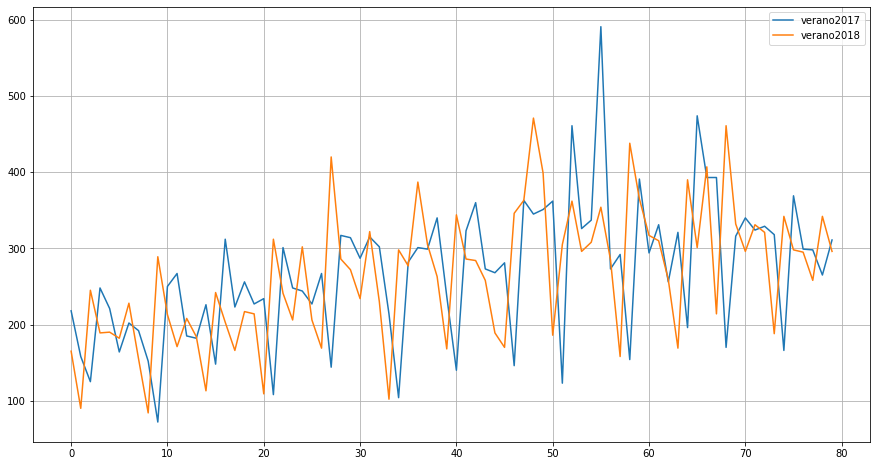

In [135]:
fig1 = plt.gcf()
fig1.set_size_inches(15,8)
verano2017 = df['2017-06-01':'2017-09-01']
plt.plot(verano2017.values, label="verano2017")
verano2018 = df['2018-06-01':'2018-09-01']
plt.plot(verano2018.values, label="verano2018")
plt.legend()
plt.grid()
plt.show()

# Preprocesado de los datos

In [136]:
PASOS=7
# el truco que convierte la temporalidad de la serie a una problema suervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # secuencia de entrada (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # secuencia de prediccion (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # ponemos todo juntico
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # omitimos con valores nulos
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# cargamos dataset
values = df.values
# todo a decimal
values = values.astype('float32')
# normalizamos las variables
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# dataframe con la serie trasformada
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
8,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
9,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
10,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
11,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444


## Dividimos en set de Entrenamiento y Validación

In [137]:
# Dividimos nuestro dataset
values = reframed.values
n_train_days = 315+289 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# separamos predictoras y objetivo
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reformamos nuestra conjunto a 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(567, 1, 7) (567,) (30, 1, 7) (30,)


# Creamos el Modelo de Red Neuronal

## Utilizaremos una Red "normal" Feedforward

In [138]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model


In [139]:
model = crear_modeloFF()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1, 7)              56        
                                                                 
 flatten_4 (Flatten)         (None, 7)                 0         
                                                                 
 dense_9 (Dense)             (None, 1)                 8         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1, 7)              56        
                                                                 
 flatten_4 (Flatten)         (None, 

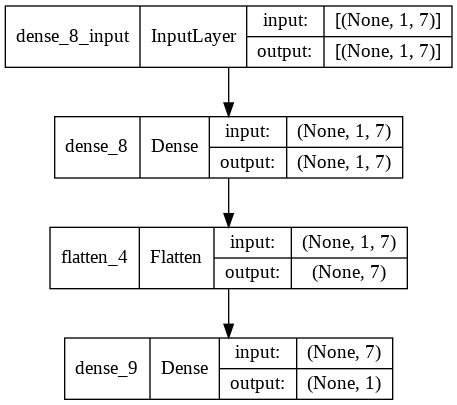

In [140]:
plot_model(model,show_shapes=True)

## Entrenamos nuestra red

In [141]:
EPOCHS=40
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS,verbose=False)

In [142]:
#Obtener Pesos de la Red
w = model.get_weights();w
#Imprimir resultados
print("Objeto Pesos:\n",w, "\n")
print("======"*15, "\n")
print('Number of Weights: '+ str(len(w)), "\n")
print("======"*15, "\n")
print('w1 = ' + str(w[0][0]) +'(Weight)', "\n")
print("======"*15, "\n")
print('bias = ' + str(w[1]))

Objeto Pesos:
 [array([[-0.06763197, -0.16923106, -0.829654  ,  0.26920864,  0.26452062,
         0.22239013, -0.16089463],
       [ 0.45325634,  0.10652349, -0.0801288 , -0.24807371,  0.12203248,
        -0.67569155, -0.19739327],
       [ 0.4049711 ,  0.40227884, -0.00897594,  0.10738198, -0.10991038,
         0.23789307, -0.09385199],
       [ 0.0896743 , -0.28097367,  0.3831027 , -0.37693626,  0.09074263,
        -0.73340523, -0.24310797],
       [-0.02735918, -0.07090177, -0.04017875,  0.26853517, -0.6355562 ,
         0.49421158,  0.60837215],
       [-0.20398982,  0.19368078,  0.26804098, -0.29370144,  0.13722031,
        -0.3709295 , -0.5288934 ],
       [-0.5952098 , -0.4652638 , -0.2120262 ,  0.60169   ,  0.41484573,
         0.05655433,  0.49779627]], dtype=float32), array([ 0.05026138, -0.08170436,  0.04919308, -0.11970273,  0.09323117,
       -0.08067267, -0.10323332], dtype=float32), array([[ 0.17387968],
       [ 0.37625122],
       [-0.63943106],
       [ 0.2142083 ],
 

In [143]:
for layer in model.layers:
    print("\n")
    print("======"*8, layer, "======"*8)
    weights = layer.get_weights() # list of numpy arrays
    print(layer,layer.get_weights())  




================================================ <keras.layers.core.dense.Dense object at 0x7f1d8863f850> ================================================
<keras.layers.core.dense.Dense object at 0x7f1d8863f850> [array([[-0.06763197, -0.16923106, -0.829654  ,  0.26920864,  0.26452062,
         0.22239013, -0.16089463],
       [ 0.45325634,  0.10652349, -0.0801288 , -0.24807371,  0.12203248,
        -0.67569155, -0.19739327],
       [ 0.4049711 ,  0.40227884, -0.00897594,  0.10738198, -0.10991038,
         0.23789307, -0.09385199],
       [ 0.0896743 , -0.28097367,  0.3831027 , -0.37693626,  0.09074263,
        -0.73340523, -0.24310797],
       [-0.02735918, -0.07090177, -0.04017875,  0.26853517, -0.6355562 ,
         0.49421158,  0.60837215],
       [-0.20398982,  0.19368078,  0.26804098, -0.29370144,  0.13722031,
        -0.3709295 , -0.5288934 ],
       [-0.5952098 , -0.4652638 , -0.2120262 ,  0.60169   ,  0.41484573,
         0.05655433,  0.49779627]], dtype=float32), array([ 0.05

## Visualizamos Resultados de entrenamiento

In [144]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

<Figure size 1152x648 with 0 Axes>

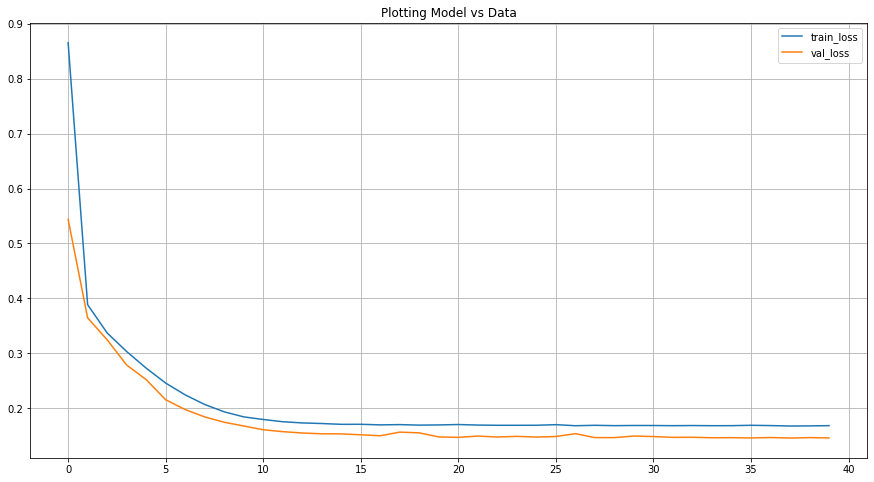

In [145]:
fig1 = plt.gcf()
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Plotting Model vs Data')
plt.legend(loc=0)
plt.grid()
plt.show()

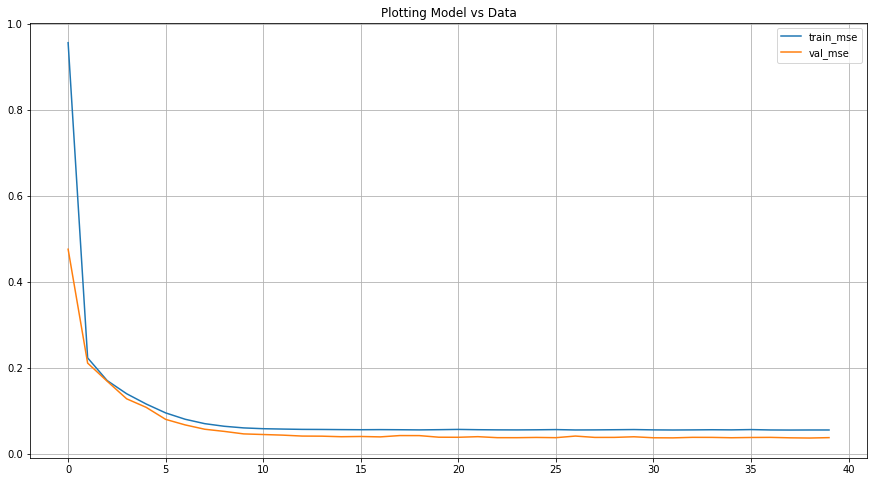

In [146]:
fig1 = plt.gcf()
fig1.set_size_inches(15,8)
plt.plot(history.history['mse'], label='train_mse')
plt.plot(history.history['val_mse'], label='val_mse')
plt.title('Plotting Model vs Data')
plt.legend(loc=0)
plt.grid()
plt.show()

## Visualizamos resultados de la predicción

30


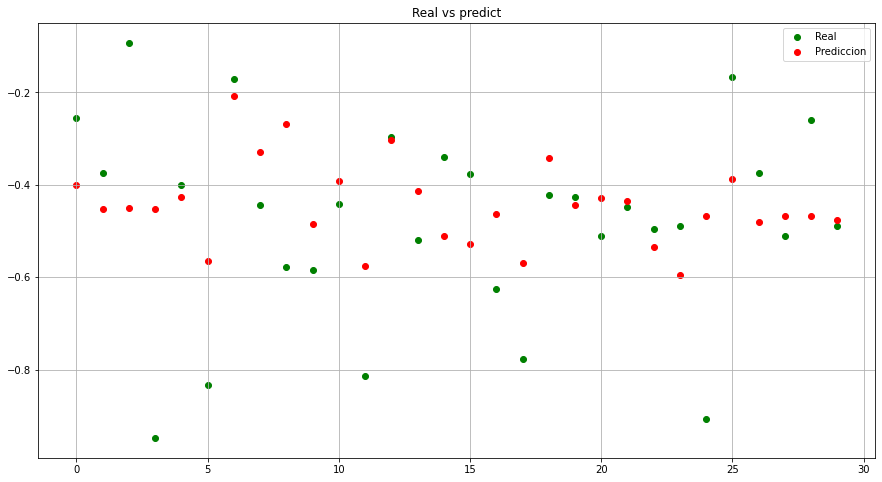

In [147]:
fig1 = plt.gcf()
fig1.set_size_inches(15,8)
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g',label="Real")
plt.scatter(range(len(results)),results,c='r',label="Prediccion")
plt.title('Real vs predict')
plt.legend()
plt.grid()
plt.show()


In [148]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head()

,real,prediccion,diferencia
0,252.000000,213.070923,38.929077
1,220.000000,198.984268,21.015732
2,296.000000,199.651917,96.348083
3,64.999992,198.581711,-133.581726
4,213.000000,206.045731,6.954269


In [149]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,191.633331,201.089127,-9.455746
std,57.580811,24.378124,51.905144
min,64.999992,160.129715,-133.581726
25%,169.000000,190.218536,-30.491837
50%,200.500000,198.782990,-3.344131
75%,220.000000,212.124191,26.752117
max,296.000000,265.080475,96.348083


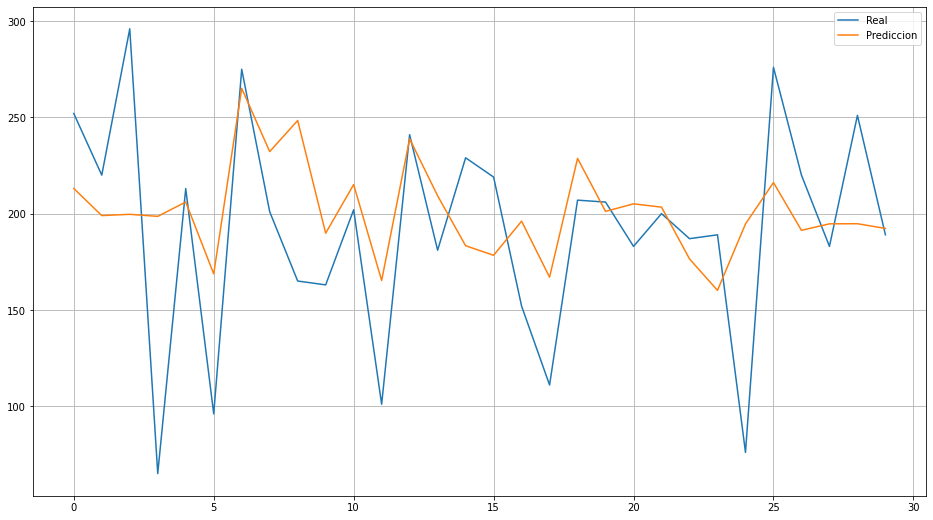

In [150]:
plt.plot(compara2.real, label="Real")
plt.plot(compara2.prediccion, label="Prediccion")
plt.legend()
plt.grid()
plt.show()

# Predicción

A partir de la última semana de noviembre 2018, intentaremos predecir la primer semana de diciembre.

In [151]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias

fecha
2018-11-16    152
2018-11-17    111
2018-11-19    207
2018-11-20    206
2018-11-21    183
2018-11-22    200
2018-11-23    187
2018-11-24    189
2018-11-25     76
2018-11-26    276
2018-11-27    220
2018-11-28    183
2018-11-29    251
2018-11-30    189
Name: unidades, dtype: int64

## Preparamos los datos para Test

In [152]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.24,-0.65,0.31,0.30,0.07,0.24,0.11
8,-0.65,0.31,0.30,0.07,0.24,0.11,0.13
9,0.31,0.30,0.07,0.24,0.11,0.13,-1.00
10,0.30,0.07,0.24,0.11,0.13,-1.00,1.00
11,0.07,0.24,0.11,0.13,-1.00,1.00,0.44
12,0.24,0.11,0.13,-1.00,1.00,0.44,0.07
13,0.11,0.13,-1.00,1.00,0.44,0.07,0.75


In [153]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[ 0.11000001,  0.13      , -1.        ,  1.        ,
          0.44000006,  0.06999993,  0.75      ]]], dtype=float32)

In [154]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

## Pronóstico para la "próxima semana"

In [155]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])
    

[[[ 0.11000001  0.13       -1.          1.          0.44000006
    0.06999993  0.75      ]]]
[[[ 0.13       -1.          1.          0.44000006  0.06999993
    0.75       -0.01904416]]]
[[[-1.          1.          0.44000006  0.06999993  0.75
   -0.01904416 -0.5359844 ]]]
[[[ 1.          0.44000006  0.06999993  0.75       -0.01904416
   -0.5359844   0.39197326]]]
[[[ 0.44000006  0.06999993  0.75       -0.01904416 -0.5359844
    0.39197326  0.36446977]]]
[[[ 0.06999993  0.75       -0.01904416 -0.5359844   0.39197326
    0.36446977  0.03624314]]]
[[[ 0.75       -0.01904416 -0.5359844   0.39197326  0.36446977
    0.03624314  0.26091263]]]


## Re-Convertimos los resultados

In [156]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.01904416], dtype=float32), array([-0.5359844], dtype=float32), array([0.39197326], dtype=float32), array([0.36446977], dtype=float32), array([0.03624314], dtype=float32), array([0.26091263], dtype=float32), array([0.01603094], dtype=float32)]


array([[174.09558723],
       [122.40156209],
       [215.19732956],
       [212.44698046],
       [179.6243175 ],
       [202.09126626],
       [177.6030975 ]])

## Visualizamos el pronóstico

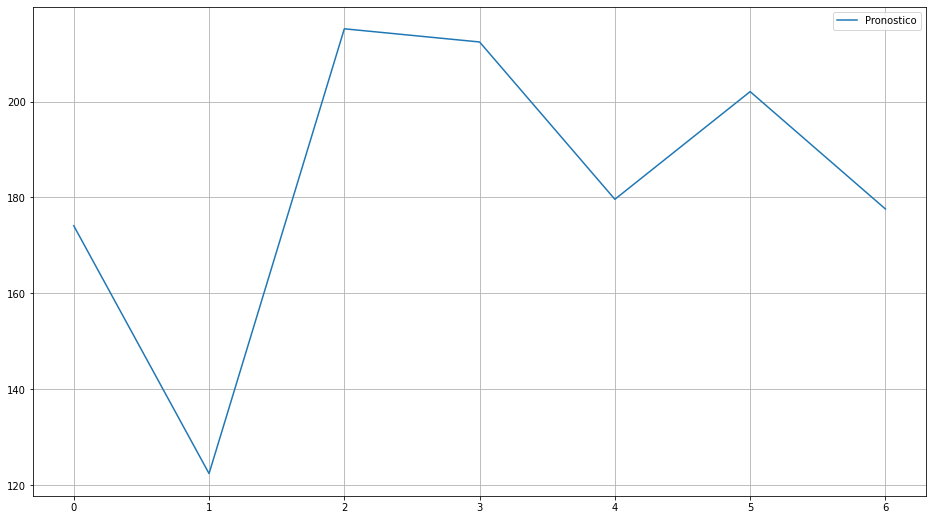

In [157]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
#prediccion1SemanaDiciembre.plot()
#prediccion1SemanaDiciembre.to_csv('pronostico.csv')
plt.plot(prediccion1SemanaDiciembre.pronostico, label="Pronostico")
plt.legend()
plt.grid()
plt.show()

In [158]:
prediccion1SemanaDiciembre

,pronostico
0,174.095587
1,122.401562
2,215.197330
3,212.446980
4,179.624318
5,202.091266
6,177.603098


# Agregamos el resultado en el dataset

In [159]:
i=0
for fila in prediccion1SemanaDiciembre.pronostico:
    i=i+1
    ultimosDias.loc['2018-12-0' + str(i) + ' 00:00:00'] = fila
    print(fila)
ultimosDias.tail(14)

174.09558722590478
122.40156208876287
215.19732956284275
212.44698045656787
179.624317503519
202.09126626159102
177.6030975044466


fecha
2018-11-24 00:00:00    189.000000
2018-11-25 00:00:00     76.000000
2018-11-26 00:00:00    276.000000
2018-11-27 00:00:00    220.000000
2018-11-28 00:00:00    183.000000
2018-11-29 00:00:00    251.000000
2018-11-30 00:00:00    189.000000
2018-12-01 00:00:00    174.095587
2018-12-02 00:00:00    122.401562
2018-12-03 00:00:00    215.197330
2018-12-04 00:00:00    212.446980
2018-12-05 00:00:00    179.624318
2018-12-06 00:00:00    202.091266
2018-12-07 00:00:00    177.603098
Name: unidades, dtype: float64

## CONCLUSIONES:
* Uno de los pasos más importantes, al realizar el pre procesado, consiste en convertir nuestra serie en un modelo de aprendizaje supervisado.
* Se evidencia en que a pesar de que la perdida en entrenamiento es baja al igual que la métrica "mse"la gráfica de prediccion versus real que el modelo nos muestra que el modelo no es eficiente.

## ACTIVIDAD
Se propone como actividad lo siguiente:
  * Variar la cantidad de EPOCHS
  * Probar otro optimizador distinto a Adam, ó configurar valores distintos de Learning Rate.
  * Cambiar la arquitectura de la Red Neuronal
  * Probar utilizando más de 7 días previos para predecir. O probar con menos días.
